In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

In [2]:
import imblearn
from imblearn.over_sampling import SMOTE
## Importing resample
from sklearn.utils import resample

# WordCloud

In [112]:
positive = pd.read_csv(r"C:\Users\nshetty\Downloads\Positive Feedback.csv", encoding = 'unicode_escape')
positive = positive.fillna('')
positive["text"] = positive["Likelihood to Recommend Reason"] + ". " + positive["Additional comments"]
positive = positive[["text"]]

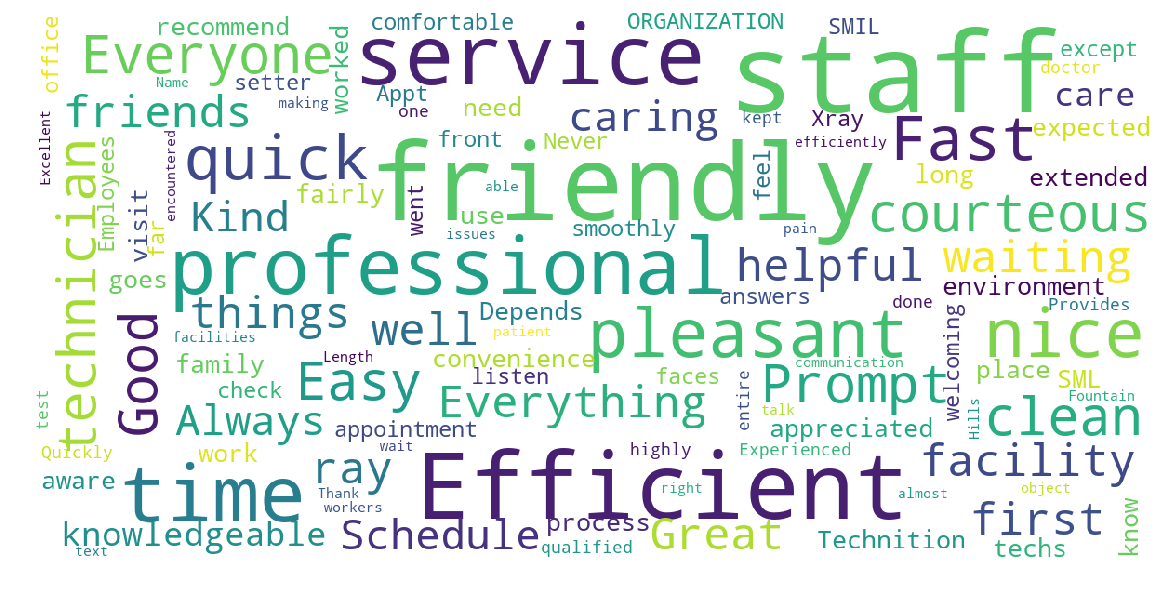

In [120]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stop_words = ["som","cl","pe","Everyon","ove","ho","goo","don","facil","facili","dtype"] + list(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stop_words,
        max_words = 200,
        max_font_size = 40,
        scale=3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.savefig('positive2.png',bbox_inches = 'tight', dpi=300)
    plt.show()
    plt.close()
    
# print wordcloud
show_wordcloud(positive["text"])

# Deep Neural Network Sentiment Analysis Modeling 

Two Classes: Negative and Positive. Collected all negative responses apart from last 2 weeks.

Attempt to put more weight towards classifying negative responses correctly, and reducing the occurence of False Positives. In order to do this, we need to find a Pareto Optimal model that optimized both Accuracy and Specificity.

## Data Preprocessing

In [ ]:
train = pd.read_csv(r"Patient Reviews.csv", encoding = 'unicode_escape')
train = train.fillna('')
train["text"] = train["Likelihood to Recommend Reason"] + ". " + train["Additional comments"]
train = train[["text","label"]]

In [28]:
train.head()

,text,label
0,. I appreciated the Technition who worked with...,1
1,Everything goes well.,1
2,Depends on convenience for family. Most are cl...,1
3,most friends do not need x-rays.,1
4,my friends aware of and/or use SML- but if som...,1


In [5]:
train.shape

(8535, 2)

In [29]:
train['label'].replace(1, 'Positive',inplace=True)
train['label'].replace(0, 'Negative',inplace=True)
train['label'].value_counts()

Positive    4292
Negative    4243
Name: label, dtype: int64

## Tokenization

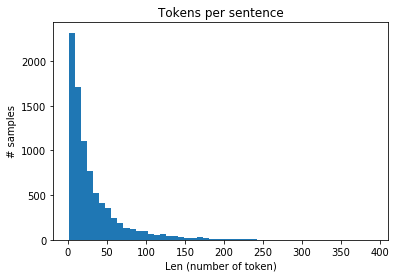

In [6]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [7]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
#x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
#x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train = train['label'].values

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 . I appreciated the Technition who worked with me.  Great job! 

First sample after preprocessing: 
 [   2  503    1 2098   64  636   20   11   62  297    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


## Architecture 

In [ ]:
BATCH_SIZE = 32
EPOCHS = 3
VOCAB_SIZE = 20000
MAX_LEN = 90
EMBEDDING_DIM = 40

In [8]:
# Model Parameters - You can play with these

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250

In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',specificity])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 90, 40)            800000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 250)           30250     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0     

In [14]:
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          verbose=2)

Train on 7681 samples, validate on 854 samples
Epoch 1/3
 - 244s - loss: 0.3221 - acc: 0.8651 - specificity: 0.7736 - val_loss: 0.1597 - val_acc: 0.9356 - val_specificity: 0.8920
Epoch 2/3
 - 236s - loss: 0.1289 - acc: 0.9531 - specificity: 0.9148 - val_loss: 0.0612 - val_acc: 0.9754 - val_specificity: 0.9569
Epoch 3/3
 - 243s - loss: 0.0848 - acc: 0.9708 - specificity: 0.9466 - val_loss: 0.2172 - val_acc: 0.9227 - val_specificity: 0.8869


# Validation

In [15]:
val = pd.read_csv(r"Sentiment Test.csv", encoding = 'unicode_escape')
val = val.fillna('')
# append the positive and negative text reviews
val["text"] = val["Likelihood to Recommend Reason"] + ". " + val["Additional comments"]
# create the label
#reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
val = val[["text"]]

In [16]:
val.head()

,text
0,This office was on time and quick to complete ...
1,Always friendly staff at SMIL!. Robyn at the f...
2,The tech who did my ultrasound calmed me down ...
3,Staff member Denise went above and beyond help...
4,The girl that performed the ultra sound was ou...


In [17]:
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

In [18]:
pred = model.predict_classes(x_val)

In [19]:
pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [20]:
val['Sentiment'] = pred
val['Sentiment'] = np.where(val['Sentiment'] == 1, 'Positive' , 'Negative')
#val.to_excel("output.xlsx")

In [21]:
val

,text,Sentiment
0,This office was on time and quick to complete ...,Positive
1,Always friendly staff at SMIL!. Robyn at the f...,Positive
2,The tech who did my ultrasound calmed me down ...,Positive
3,Staff member Denise went above and beyond help...,Positive
4,The girl that performed the ultra sound was ou...,Positive
5,The whole process was very smooth and was a pl...,Positive
6,Staff and technician were courteous and effici...,Positive
7,It was a little hard to get the approval from ...,Positive
8,Friendly staff. Amber the rad tech was profess...,Positive
9,The technician Kim was so loving caring and so...,Positive


In [269]:
val.to_excel("output6.xlsx")